# Upwelling velocities notebook

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
import os
from datetime import datetime
from matplotlib import gridspec
from salishsea_tools import grid_tools, tidetools, viz_tools, places, utilities

%matplotlib inline
plt.rcParams['font.size'] = 12

## Local functions

In [3]:
def make_pressure_diagram():
    """Quick plotting code for pressure diagram
    """

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0.1, 0.8])
    ax.yaxis.set_ticklabels(['$z=-h$', '$z=0$'])

    # Add lines
    x = np.arange(0, 1.01, 0.01)
    ax.plot([0, 1], [0.8, 0.8], 'k--')
    ax.plot([0, 1], [0.1, 0.1], 'k--')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/6 + 0.8, 'k-')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/15 + 0.1, 'k-')

    # Add labels
    ax.arrow(0.5, 0.8, 0, 0.14, head_width=0.01, fc='k')
    ax.arrow(0.5, 0.105, 0, 0.04, head_width=0.01, fc='k')
    ax.arrow(0.24, 0.1, 0, 0.68, head_width=0.01, fc='k')
    ax.arrow(0.48, 0.175, 0, 0.765, head_width=0.01, fc='k')
    ax.text(0.505, 0.86, '$\eta$')
    ax.text(0.505, 0.12, '$\\xi$')
    ax.text(0.245, 0.5, '$\sum_k^0e3t(0)$')
    ax.text(0.485, 0.5, '$\sum_k^0e3t(t)$')

    plt.show()
    
    return

In [25]:
def load_results(t, rundir, prefix, maskfile, xrange=[None], yrange=[None]):
    """
    """

    # Load netCDF files
    T = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_T.nc'))
    U = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_U.nc'))
    V = xr.open_dataset(os.path.join(rundir, f'{prefix}_grid_V.nc'))
    mask = xr.open_dataset(maskfile)
    
    # Define slices
    xslice = slice(*xrange)
    yslice = slice(*yrange)
    
    # Define parameters
    params = {
        'x': mask.x[xslice].values,
        'y': mask.y[yslice].values,
        'u': U.vozocrtx[t, :, yslice, xslice].values,
        'v': V.vomecrty[t, :, yslice, xslice].values,
        'eta': T.sossheig[t, yslice, xslice].values,
        'tmask': mask.tmask[0, :, yslice, xslice].values,
        'gdept_0': mask.gdept_0[0, :, yslice, xslice].values,
        'e1t': mask.e1t[0, yslice, xslice].values,
        'e2t': mask.e2t[0, yslice, xslice].values,
        'e3t_0': mask.e3t_0[0, :, yslice, xslice].values,
    }
    
    # Obtain the time dependent grid parameters
    VVL = grid_tools.calculate_time_dependent_grid(
        params['e3t_0'], params['tmask'], params['eta'][np.newaxis, ...],
        {'e3t_t': params['e3t_0'][np.newaxis, ...], 'gdept_t': params['gdept_0'][np.newaxis, ...]},
    )
    
    # Calculate rho
    rho = gsw.rho(T.vosaline[t, :, yslice, xslice], T.votemper[t, :, yslice, xslice], VVL['gdept_t'][0, ...])
    
    params.update({
        'rho': rho,
        'e3t_t': VVL['e3t_t'][0, ...],
        'gdept_t': VVL['gdept_t'][0, ...],
    })
    
    return params

In [ ]:
def calc_sigma_surface():
    """Calculate 1022 surface depth
    """
    
    index = abs(rho - 1022).argmin(axis=1)
    p, _, m, n = VVL['gdept_t'].shape
    depth_1022 = np.zeros((p, m, n))
    for t in range(p):
        for j in range(m):
            for i in range(n):
                depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]
                
    return depth_1022

In [70]:
def plotit(z, GEO, params, plevels=np.arange(35.128, 35.14, 0.001), height=18, scale=1, lims=[20, 125, 0, 470]):
    """Plot idealized model results
    """
    
    fig, axs = plt.subplots(1, 4, figsize=(17, height))
    cax = fig.add_axes([0.29, 0.15, 0.01, 0.7])

    for ax, tag in zip(axs, ['p', '', '_g', '_a']):
        if tag is 'p':
            levels = plevels
            c = ax.contourf(params['x'], params['y'], GEO['pressure']*1e-4, levels=levels, cmap=cmocean.cm.deep, extend='both', zorder=0)
        else:
            mindex = (abs(GEO[f'u{tag}']) > 0.1) | (abs(GEO[f'v{tag}']) > 0.1)
            u = np.ma.masked_where(mindex, GEO[f'u{tag}'])
            v = np.ma.masked_where(mindex, GEO[f'v{tag}'])
            q = ax.quiver(params['x'][::5], params['y'][::5], u[::5, ::5], v[::5, ::5], scale=scale, zorder=2)
            ax.yaxis.set_ticklabels('')
        ax.contourf(params['x'], params['y'], params['tmask'][z, ...], levels=[-0.01, 0.01], colors='Burlywood', zorder=1)
        ax.contour(params['x'], params['y'], params['tmask'][z, ...], levels=[-0.01, 0.01], colors='k', zorder=1)
        ax.set_xlim(lims[:2])
        ax.set_ylim(lims[2:])
        viz_tools.set_aspect(ax)

    axs[3].quiverkey(q, 0.15, 0.97, 0.05, '0.05 m/s')

    fig.colorbar(c, cax=cax)
    
    return

## Velocity decomposition
We would like to show that the ageostrophic velocities in the lower layer of the model are onshore and stronger near protruding coastlines.

First we calculate the total pressure field

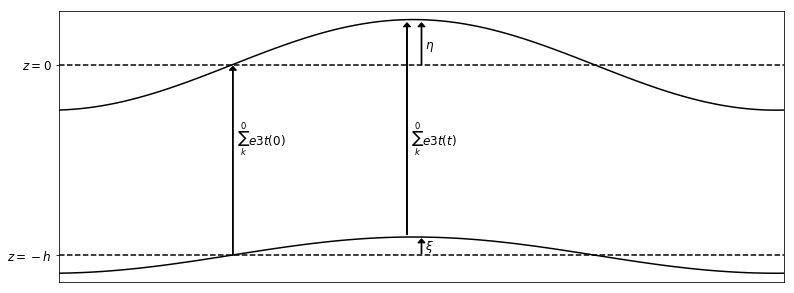

In [11]:
make_pressure_diagram()

$$\xi = \eta - \left(\sum_k^0e3t(t) - \sum_k^0e3t(0)\right)$$

$$p = g\int_{-h}^\eta\rho dz = g\int_{-h+\xi}^\eta\rho dz + g\rho_{deep}\xi$$

Next, we calculate the geostrophic velocities from the pressure gradient force.

$$f \times \mathbf{u}_g = -\frac{1}{\rho}\nabla p$$

$$\mathbf{u}_a = \mathbf{u} - \mathbf{u}_g$$

In [17]:
def calc_geostrophic_velocities(z, params, corr=False):
    """Calculate pressure gradients and geostrophic velocities at idepth
    """

    # Gravitational acceleration
    g = 9.81
    f = 1e-4

    # Calculate z surface displacement xi
    stretching = params['e3t_t'][:z, ...].sum(axis=0) - params['e3t_0'][:z, ...].sum(axis=0)
    xi = params['eta'] - stretching

    # Define rho at z surface
    rho_bot = params['rho'][z, ...]
    rho_bot[xi < 0] = params['rho'][z - 1, ...][xi < 0]

    # Calculate pressure
    pressure = g * ((params['rho'][:z, ...] * params['e3t_t'][:z, ...]).sum(axis=0) + rho_bot * xi)
    
    if corr:
        py = np.ma.masked_where(params['tmask'][z, ...] == 0, pressure).mean(axis=1)[..., np.newaxis]
        pressure = pressure - py + py.mean(axis=0)

    # Calculate the pressure gradient
    dpdy, dpdx = np.gradient(pressure, axis=(0, 1))

    # Extract and unstagger the model velocity fields
    u = params['u'][z, ...]
    v = params['v'][z, ...]
    u[1:, 1:], v[1:, 1:] = viz_tools.unstagger(u, v)

    # Calculate the geostrophic velocities
    u_g = -1 / (f * params['rho'][z, ...]) * dpdy / params['e2t']
    v_g = 1 / (f * params['rho'][z, ...]) * dpdx / params['e1t']

    # Calculate ageostrophic velocities
    u_a = u - u_g
    v_a = v - v_g

    # Filter tides
    GEO = {
        'u': u,                     #tidetools.filter_timeseries(u),
        'v': v,                     #tidetools.filter_timeseries(v),
        'u_g': u_g,                 #tidetools.filter_timeseries(u_g),
        'v_g': v_g,                 #tidetools.filter_timeseries(v_g),
        'u_a': u_a,                 #tidetools.filter_timeseries(u_a),
        'v_a': v_a,                 #tidetools.filter_timeseries(v_a),
        'pressure': pressure,       #tidetools.filter_timeseries(pressure),
    }

    return GEO

## Idealized configuration

In [72]:
rundir = '/data/bmoorema/results/SalishSeaPond/SalishSeaPond_basic_summer_S24H_2layer'
prefix = 'SalishSeaIdeal_1h_20170701_20170705'
maskfile = os.path.join(rundir, 'mesh_mask.nc')
z = 24
t = 40
lims=[20, 125, 0, 470]
params = load_results(t, rundir, prefix, maskfile, xrange=lims[:2], yrange=lims[2:])

### No correction

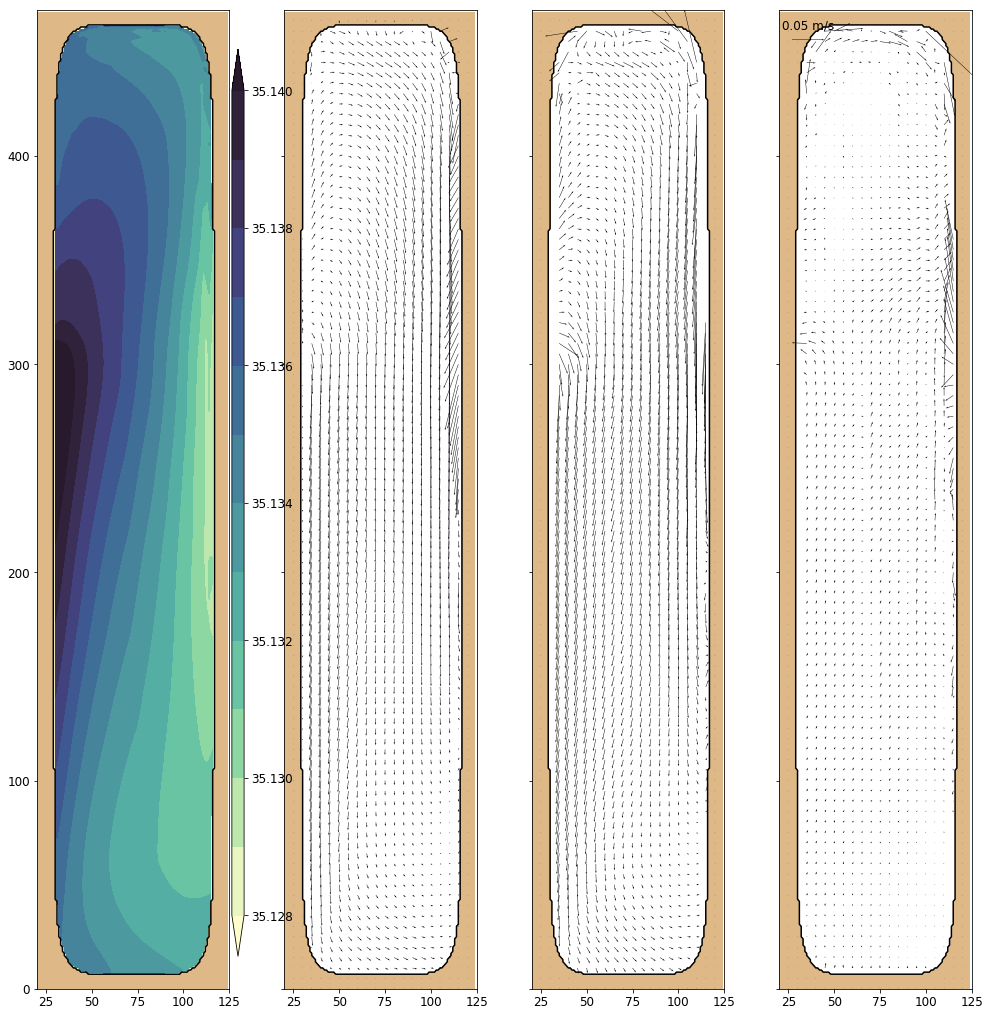

In [77]:
GEO = calc_geostrophic_velocities(z, params)
plotit(z, GEO, params, scale=0.3, lims=lims)

### With correction

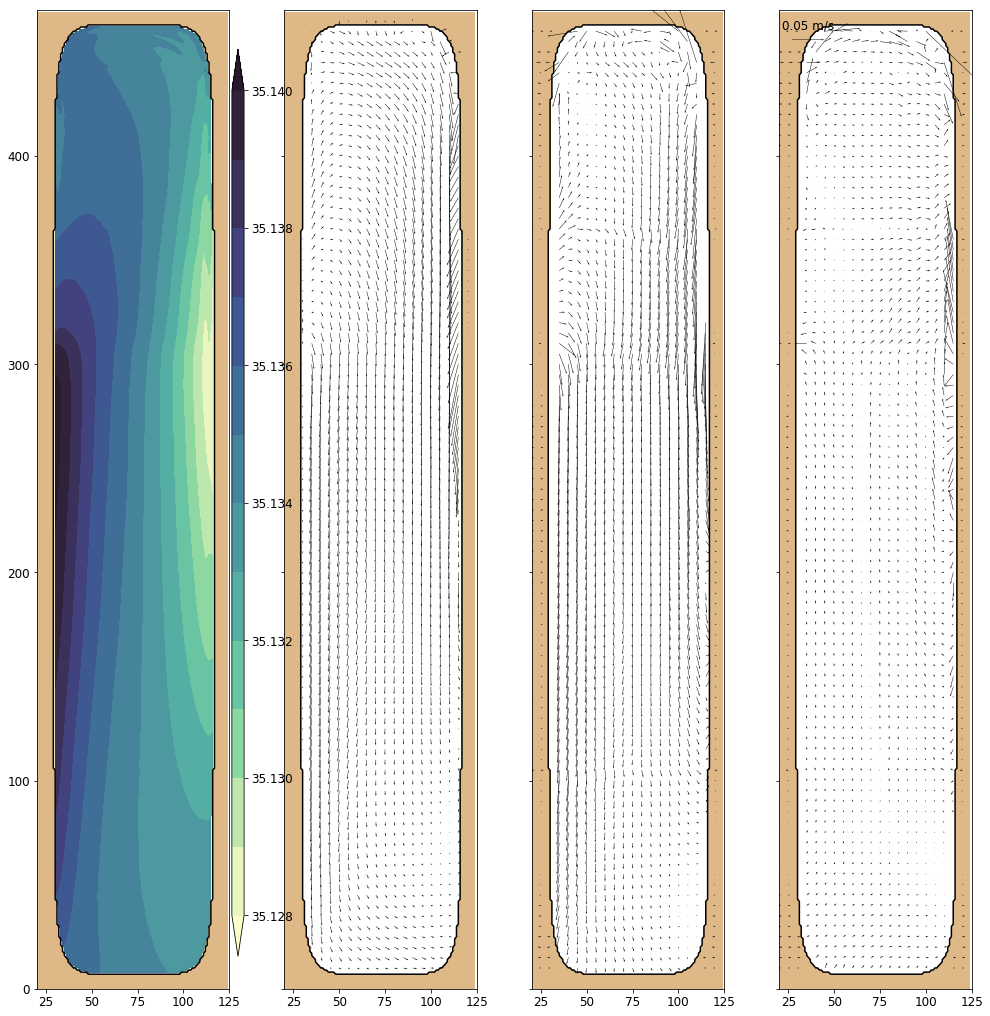

In [78]:
GEO = calc_geostrophic_velocities(z, params, corr=True)
plotit(z, GEO, params, scale=0.3, lims=lims)

## Full configuration - no tides

In [80]:
rundir = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake'
prefix = 'SalishSea_1h_20150424_20150429'
maskfile = '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc'
z = 23
t = 70
lims=[100, 300, 400, 750]
params = load_results(t, rundir, prefix, maskfile, xrange=lims[:2], yrange=lims[2:])

### No correction

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


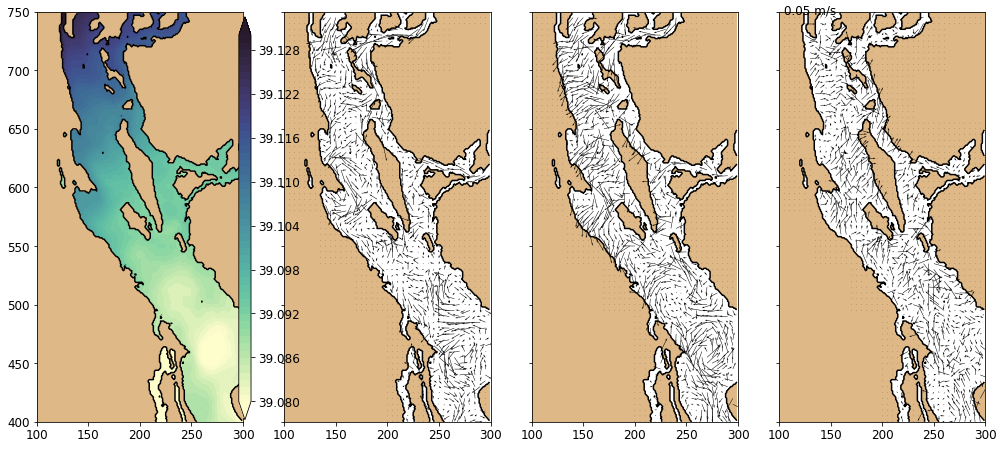

In [81]:
GEO = calc_geostrophic_velocities(z, params)
plotit(z, GEO, params, plevels=np.arange(39.08, 39.13, 0.001), height=8, lims=lims)

### With correction

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


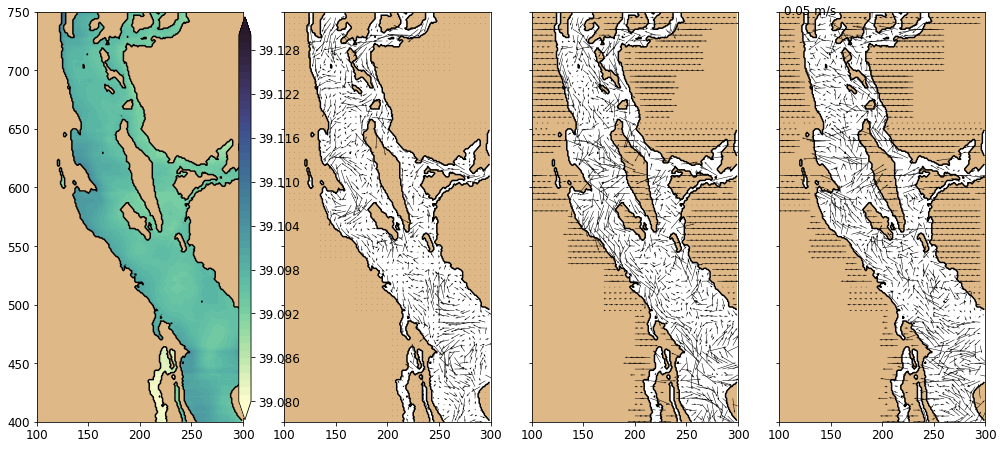

In [82]:
GEO = calc_geostrophic_velocities(z, params, corr=True)
plotit(z, GEO, params, plevels=np.arange(39.08, 39.13, 0.001), height=8, lims=lims)